import packages
------------------

Some packages are installed automatically if you use Anaconda. As pytorch is used here, you are expected to install that in your machine. 

In [ ]:
# previous verions: Copy of step002_det_P002_segDistTransform_v9_eval_2022_02_09.ipynb

In [1]:
from google.colab import drive
# drive.flush_and_unmount()
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
# added to be able to run in Google Colab
import sys
sys.path.append('/content/gdrive/MyDrive/UTRECHT/utils')
sys.path.insert(0,'/content/gdrive/MyDrive/UTRECHT')

import utils

In [3]:
from __future__ import print_function, division
import os, random, time, copy
from skimage import io, transform, morphology, feature, measure
from skimage.morphology import dilation, square, binary_opening
from skimage.draw import rectangle_perimeter
import numpy as np
import os.path as path
import scipy.io as sio
import scipy
from scipy import misc
from scipy import ndimage, signal
from scipy.ndimage import gaussian_filter
import pickle
import sys
import math
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import PIL.Image
from io import BytesIO
from skimage import data, img_as_float
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
import pandas as pd 
import matplotlib.patheffects as path_effects

from skimage.filters import threshold_otsu

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler 
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision
from torchvision import datasets, models, transforms

# sys.path.append('/home/skong2/project/dpff4ldl')
# from utils.metrics import *
# from losses import *

from utils.flow_functions import *
from utils.dataset import *
from utils.network_arch import *
from utils.trainval_detSegDistTransform import *

import warnings # ignore warnings
warnings.filterwarnings("ignore")
print(sys.version)
print(torch.__version__)

3.8.16 (default, Dec  7 2022, 01:12:13) 
[GCC 7.5.0]
1.13.0+cu116




Evaluation and Visualization
-----

In [4]:
# Here define the path, which is used to save the log and trained model in training process

project_name = 'generalizedDet_finetuned_2023_01_10_T1T2T3_forExp2'
Tminus1_project_name = 'generalizedDet_2022_10_18'


# cpu or cuda
device ='cpu'
if torch.cuda.is_available(): 
    device='cuda:0'
print(device)

freqShow = 50
weight_reg = 2.0    # balances regression loss with segmentation loss. Value chosen based on past investigation.
weight_background = 0.1   # for regression loss only, downweights background pixels to highlight foreground pollen

#model parameters
batch_size = 4
newSize = [800,800] # set to crop size, to tell model what size tensor to expect
total_epoch_num = 60  # total number of epoch in training
base_lr =0.0005        #0.0005      # base learning rate/
scaleList = [0]      # the number of output layer for U-net
#scale = [0,1,2,3]      # the number of output layer for U-net


exp_dir = '/content/gdrive/MyDrive/exp/final' # experiment directory, used for reading the init model
save_dir = os.path.join(exp_dir, project_name) # where to save the log file and trained models.
if not os.path.exists(save_dir): 
    os.makedirs(save_dir)
log_filename = os.path.join(save_dir, 'train.log')

cuda:0


In [5]:
eval_dir = '/content/gdrive/MyDrive/eval/final' 
eval_dir = os.path.join(eval_dir, project_name) 
if not os.path.exists(eval_dir): 
    os.makedirs(eval_dir)
print(eval_dir)

/content/gdrive/MyDrive/eval/final/generalizedDet_finetuned_2023_01_10_T1T2T3_forExp2


In [6]:
# path_to_image = '/content/gdrive/MyDrive/UTRECHT/Detection/PAL1999/C6/C6_tiles_withAnnot'
path_to_image = '/content/gdrive/MyDrive/UTRECHT/Detection/PAL1999'
with open(os.path.join(save_dir,'dbinfo.plk'), 'rb') as handle:
    dbinfo = pickle.load(handle)    
    
dbinfo.keys(), len(dbinfo['train_det_list']), len(dbinfo['test_det_list'])

(dict_keys(['train_det_list', 'test_det_list']), 720, 180)

In [7]:
################## init model ###################
# path_to_save_paramOnly = path.join(exp_dir, project_name, 'bestValModel_encoder_1.paramOnly')
# path_to_save_paramOnly = path.join(exp_dir, project_name, 'epoch-84_encoder.paramOnly')
path_to_save_paramOnly = path.join(exp_dir, Tminus1_project_name, 'bestValModel_encoder.paramOnly')

curmodel = PollenDet_SegDistTransform(34, scaleList=scaleList, pretrained=False)
curmodel.encoder.encoder.conv1 = nn.Conv2d(27, 64, (7, 7), (2, 2), (3, 3), bias=False) #change dimensions of the first layer in the encoder
curmodel.load_state_dict(torch.load(path_to_save_paramOnly)) #, map_location=torch.device('cpu')
curmodel.to(device);    
#print(curmodel.state_dict)
curmodel.eval()
#curmodel.train()
curmodel.training = False
print(curmodel.training)
print(path_to_save_paramOnly)

False
/content/gdrive/MyDrive/exp/final/generalizedDet_2022_10_18/bestValModel_encoder.paramOnly


In [8]:
class PollenDet4Eval(Dataset):
    def __init__(self, path_to_image='/content/gdrive/MyDrive/UTRECHT/Detection/PAL1999',
                #  path_to_annot='/content/gdrive/MyDrive/UTRECHT/Detection/AnnotCombo9_noNPP_circleMask',
                 path_to_mask='/content/gdrive/MyDrive/UTRECHT/Detection/PAL1999',
                 dbinfo=dbinfo,
                 size=[1040,1392], 
                 set_name='test'):
        
        self.path_to_image = path_to_image
        # self.path_to_annot = path_to_annot
        self.path_to_mask = path_to_mask
        self.transform = transform
        self.dbinfo = dbinfo
        if set_name=='val':
            set_name = 'test'
        self.set_name = set_name        
        self.size = size
        self.resizeFactor = size[0]/1000
        
        self.sampleList = self.dbinfo[set_name+'_det_list']

        self.TFNormalize = transforms.Normalize([0.5] * 27, [0.5]*27)
        self.current_set_len = len(self.sampleList)
        
        self.TF2tensor = transforms.ToTensor()
        self.TF2PIL = transforms.ToPILImage()
        self.TFresize = transforms.Resize((self.size[0],self.size[1]))

    def __len__(self):        
        return self.current_set_len
    
    def __getitem__(self, idx):        
        current_example= self.sampleList[idx] 

        current_image_path= os.path.join(self.path_to_image, current_example[0], current_example[0] + '_tiles_withAnnot', current_example[1],current_example[2])
        current_distTransform_path=os.path.join(self.path_to_image, current_example[0], current_example[0] + '_masks2', current_example[1],current_example[2])
        # curPickleName = path.join(self.path_to_annot, current_example)

        imagestack_array = []
        for file in sorted(os.listdir(current_image_path)):
          if file.endswith('.png'):
            slice = Image.open(os.path.join(current_image_path, file))
            imagestack_array.append(np.asarray(slice))
        image = np.block(imagestack_array)
        if image.shape[2] <27:
          pad_val = 27-image.shape[2]
          npad = ((0, 0), (0,0), (0,pad_val))
          image= np.pad(image, pad_width=npad, mode='constant', constant_values=0)

        for file in sorted(os.listdir(current_distTransform_path)):
          if file.endswith('.png'):
            mask = Image.open(os.path.join(current_distTransform_path, file))
            mask=np.expand_dims(mask, axis=2)           

        label = np.copy(mask)         # 11/30/21 added
        label[label > 0] = 1          # 11/30/21 added       

        image_label = np.concatenate((image, label, mask), axis=2) #12/13/21 added


        mask_distanceTransform = np.copy(mask)     #11/18/21 edited
        
        labelOrgSize = np.copy(mask)
        labelOrgSize = torch.from_numpy(labelOrgSize).unsqueeze(0).unsqueeze(0).squeeze(4)

        mask_distanceTransform = mask_distanceTransform.astype(np.float32)/100.0/self.resizeFactor  # factor=size[0]/1000

        image = self.TF2tensor(image)
        label = torch.from_numpy(label).unsqueeze(0) # self.TF2tensor(label)       
        mask_distanceTransform = torch.from_numpy(mask_distanceTransform).unsqueeze(0) # self.TF2tensor(mask_distanceTransform)

        image = image.unsqueeze(0)
        label = label.unsqueeze(0)        
        mask_distanceTransform = mask_distanceTransform.unsqueeze(0)       

        height,width,layer = image_label.shape
        crop0 = image_label[0:800, 0:800,:]
        crop1 = image_label[0:800, width-800:,:]
        crop2 = image_label[height-800:, 0:800,:]
        crop3 = image_label[height-800:, width-800:,:]

        croplist = [crop0, crop1, crop2, crop3]
        imgList=[]
        labelList=[]
        mask_DTList=[]

        for idx2 in range(len(croplist)):
          image_label = croplist[idx2]
          image_label = self.TF2tensor(image_label)
          image_label = image_label.unsqueeze(0)  
          image = torch.narrow(image_label, 1, 0, image_label.shape[1]-2) 
          label=torch.narrow(image_label, 1, image_label.shape[1]-2, 1) 
          mask_distanceTransform=torch.narrow(image_label, 1, image_label.shape[1]-1, 1)

          image_label = image_label.squeeze(0)
          image = image.type(torch.float)
          image = self.TFNormalize(image)

          imgList.append(image)
          labelList.append(label)
          mask_DTList.append(mask_distanceTransform)

        image = torch.concat(imgList)
        label = torch.concat(labelList)
        mask_distanceTransform = torch.concat(mask_DTList)

        image = image.squeeze(0)
        label = label.squeeze(0)
        mask_distanceTransform = mask_distanceTransform.squeeze(0)
        labelOrgSize = labelOrgSize.squeeze(0)

        return image, label, mask_distanceTransform, labelOrgSize, current_example
        # return image, label, mask_distanceTransform, mask_overlap, mask_voteX, mask_voteY, mask_peaks, mask_radius, labelOrgSize, mask_peaksOrgSize, mask_distanceTransformOrgSize, mask_radiusOrgSize

In [9]:
set_name = 'test'
det_datasets = PollenDet4Eval(path_to_image=path_to_image,
                              # path_to_annot=path_to_annotCombo,
                              dbinfo=dbinfo, size=newSize, set_name=set_name)

dataloaders = DataLoader(det_datasets,
                         batch_size=1,
                         shuffle=True, 
                         num_workers=8) # num_work can be set to batch_size



In [10]:
print(dbinfo['test_det_list'])

[('C3', 'PAL1999_C3_sample43_slide1', '41760x_76960y'), ('C3', 'PAL1999_C3_sample43_slide1', '77952x_14560y'), ('C3', 'PAL1999_C3_sample43_slide1', '77952x_83200y'), ('C3', 'PAL1999_C3_sample43_slide1', '43152x_72800y'), ('C3', 'PAL1999_C3_sample43_slide1', '73776x_19760y'), ('C3', 'PAL1999_C3_sample43_slide1', '32016x_33280y'), ('C3', 'PAL1999_C3_sample43_slide1', '37584x_36400y'), ('C3', 'PAL1999_C3_sample43_slide1', '57072x_89440y'), ('C3', 'PAL1999_C3_sample43_slide1', '34800x_75920y'), ('C3', 'PAL1999_C3_sample43_slide1', '77952x_52000y'), ('C3', 'PAL1999_C3_sample43_slide1', '32016x_34320y'), ('C3', 'PAL1999_C3_sample43_slide1', '34800x_49920y'), ('C3', 'PAL1999_C3_sample43_slide1', '70992x_16640y'), ('C3', 'PAL1999_C3_sample43_slide1', '48720x_5200y'), ('C3', 'PAL1999_C3_sample43_slide1', '54288x_3120y'), ('C3', 'PAL1999_C3_sample43_slide1', '22272x_73840y'), ('C3', 'PAL1999_C3_sample43_slide1', '22272x_5200y'), ('C3', 'PAL1999_C3_sample43_slide1', '9744x_39520y'), ('C3', 'PAL19

In [11]:
sampler = iter(dataloaders)

In [12]:
print(len(dataloaders))

180


In [13]:
curImg, curLabel, curMask, curMask_orgSize, current_example = next(sampler)
# curImg, curBinaryMask, curDTMask, curImgPath = next(sampler)
print(current_example)

curImg = curImg.to(device)
# curImg, curLabel, curMask, curMask_orgSize = curImg.to(device), curLabel.to(device), curMask.to(device), curMask_orgSize.to(device)
curImg_squeeze=torch.squeeze(curImg,0)

outputs = curmodel(curImg_squeeze)
predSeg = outputs[('segMask', 0)]
predDistTransform = outputs[('output', 0)]

[('C3',), ('PAL1999_C3_sample1_slide2',), ('56704x_59760y',)]


In [14]:
print(current_example[1][0])

PAL1999_C3_sample1_slide2


In [15]:
print(predSeg.shape)

torch.Size([4, 1, 800, 800])


In [16]:
# m = nn.Softmax(dim=0)
# softmax = m(predDistTransform) # use image
softmax = predSeg

# print(softmax)

In [17]:
print(predSeg.max(),predSeg.min())


tensor(0.1561, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.0022, device='cuda:0', grad_fn=<MinBackward1>)


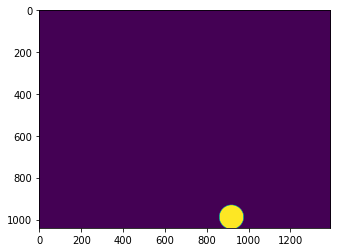

In [18]:
curmask_OrgSize = curMask_orgSize.squeeze().cpu().detach().numpy()
curmask_OrgSize_binary = curmask_OrgSize >0
plt.imshow(curmask_OrgSize_binary)

In [19]:
# create a list of (800x800) prediction distance transforms crops and softmax crops

predDistTransform_crops=[]
softmax_crops = []

for idx in range(0,4):
  tmpImg =  predDistTransform[idx,:,:,:].squeeze().cpu().detach().numpy() 
  predDistTransform_crops.append(tmpImg)

for idx in range(0,4):
  tmpImg =  softmax[idx,:,:,:].squeeze().cpu().detach().numpy() 
  softmax_crops.append(tmpImg)


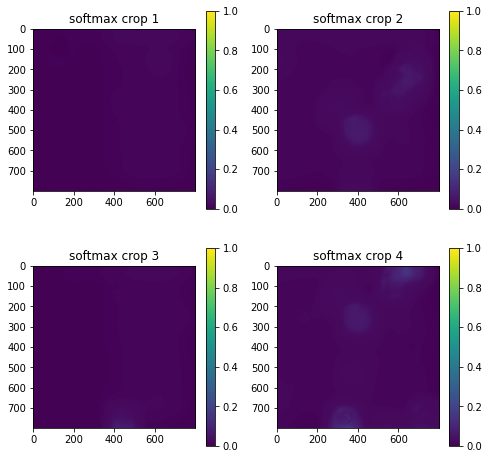

In [20]:
numSample2Show = 1
figWinNumHeight, figWinNumWidth = 2, 2
plt.figure(figsize=(8,8), facecolor='w', edgecolor='k') # figsize -- inch-by-inch
plt.clf()
subwinCount = 1    

plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
subwinCount += 1
tmpImg =  softmax_crops[0]
plt.imshow(tmpImg, vmin=0, vmax=1)
plt.title('softmax crop 1')
plt.colorbar()

plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
subwinCount += 1
tmpImg =  softmax_crops[1]
plt.imshow(tmpImg, vmin=0, vmax=1)
plt.title('softmax crop 2')
plt.colorbar()

plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
subwinCount += 1
tmpImg =  softmax_crops[2]
plt.imshow(tmpImg, vmin=0, vmax=1)
plt.title('softmax crop 3')
plt.colorbar()

plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
subwinCount += 1
tmpImg =  softmax_crops[3]
plt.imshow(tmpImg, vmin=0, vmax=1)
plt.title('softmax crop 4')
plt.colorbar()

0.28044602
0.20247814
(1040, 1392)


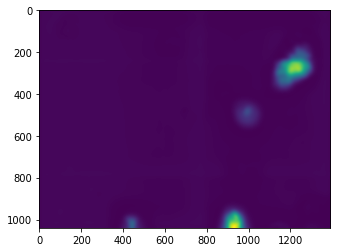

In [21]:
# create full-sized pred distance transform 

mask_OrgSize = curMask_orgSize.squeeze().cpu().detach().numpy()

height,width = mask_OrgSize.shape
predDistTransform=np.zeros_like(mask_OrgSize)  
predDistTransform=predDistTransform.astype(np.float32)

tmp_predDistTransform_1=np.zeros_like(mask_OrgSize).astype(np.float32)
tmp_predDistTransform_2=np.zeros_like(mask_OrgSize).astype(np.float32)
tmp_predDistTransform_3=np.zeros_like(mask_OrgSize).astype(np.float32)
tmp_predDistTransform_4=np.zeros_like(mask_OrgSize).astype(np.float32)


tmp_predDistTransform_1[0:800, 0:800]=predDistTransform_crops[0]
tmp_predDistTransform_2[0:800, width-800:]=predDistTransform_crops[1]
tmp_predDistTransform_3[height-800:, 0:800]=predDistTransform_crops[2]
tmp_predDistTransform_4[height-800:, width-800:]=predDistTransform_crops[3]

predDistTransform = np.maximum.reduce([tmp_predDistTransform_1,tmp_predDistTransform_2,tmp_predDistTransform_3,tmp_predDistTransform_4]) 

print(np.amax(predDistTransform))
# if np.amax(predDistTransform)>1:
#   predDistTransform *= 1/predDistTransform.max() 

predDistTransform = gaussian_filter(predDistTransform, sigma=10) # gaussian blur to get rid of shadow
print(np.amax(predDistTransform))

# im = Image.fromarray(predDistTransform.astype(np.uint8))
plt.imshow(predDistTransform)
print(predDistTransform.shape)
# print(predDistTransform.dtype)
# im.save(os.path.join(eval_save_to_folder, 'predDistTransform_full.png'))

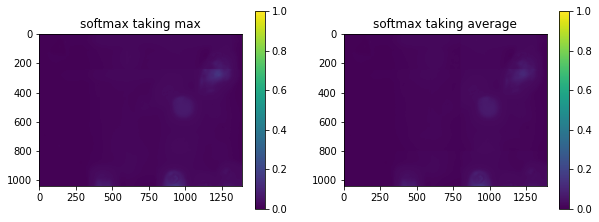

In [22]:
# create full-sized softmax

# mask_OrgSize = curMask_orgSize.squeeze().cpu().detach().numpy()

height,width = mask_OrgSize.shape
softmax=np.zeros_like(mask_OrgSize)  
softmax=softmax.astype(np.float32)

tmp_softmax_1=np.zeros_like(mask_OrgSize).astype(np.float32)
tmp_softmax_2=np.zeros_like(mask_OrgSize).astype(np.float32)
tmp_softmax_3=np.zeros_like(mask_OrgSize).astype(np.float32)
tmp_softmax_4=np.zeros_like(mask_OrgSize).astype(np.float32)

tmp_softmax_1[0:800, 0:800]=softmax_crops[0]
tmp_softmax_2[0:800, width-800:]=softmax_crops[1]
tmp_softmax_3[height-800:, 0:800]=softmax_crops[2]
tmp_softmax_4[height-800:, width-800:]=softmax_crops[3]

# softmax = np.maximum.reduce([tmp_softmax_1,tmp_softmax_2,tmp_softmax_3,tmp_softmax_4]) 
# softmax = np.mean( np.array([tmp_softmax_1,tmp_softmax_2,tmp_softmax_3,tmp_softmax_4]), axis=0 )

numSample2Show = 1
figWinNumHeight, figWinNumWidth = 2, 2
plt.figure(figsize=(10,8), facecolor='w', edgecolor='k') # figsize -- inch-by-inch
plt.clf()
subwinCount = 1    

plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
subwinCount += 1
tmpImg =  np.maximum.reduce([tmp_softmax_1,tmp_softmax_2,tmp_softmax_3,tmp_softmax_4]) 
plt.imshow(tmpImg, vmin = 0, vmax = 1)
plt.title('softmax taking max')
plt.colorbar()

tmp_softmax_1[tmp_softmax_1 == 0] = np.nan
tmp_softmax_2[tmp_softmax_2 == 0] = np.nan
tmp_softmax_3[tmp_softmax_3 == 0] = np.nan
tmp_softmax_4[tmp_softmax_4 == 0] = np.nan

plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
subwinCount += 1
tmpImg =  np.nanmean(np.array([tmp_softmax_1,tmp_softmax_2,tmp_softmax_3,tmp_softmax_4]), axis=0)
softmax=tmpImg
plt.imshow(tmpImg, vmin = 0, vmax = 1)
plt.title('softmax taking average')
plt.colorbar()


# # plt.imshow(softmax)
# print(softmax.shape)

In [23]:
predBinaryMask = softmax>0.4
predBinaryMask=binary_opening(predBinaryMask,square(5))
predBinaryMask = dilation(predBinaryMask,square(10))
# plt.imshow(predBinaryMask)

In [24]:
predSegMask = measure.label(predBinaryMask, background=0)
# plt.imshow(predSegMask, cmap='viridis')

In [25]:
def create_circular_mask(mask, center, radius, value=1):
    h, w = mask.shape[:2]
    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((Y - center[0])**2 + (X-center[1])**2)

    tmpMask = dist_from_center <= radius
    mask[tmpMask] = value
    
    return mask

In [26]:
pred_distanceTransform = np.copy(predDistTransform)

voting4center = np.copy(pred_distanceTransform)
voting4center[voting4center<0.05] = 0 #changed from voting4center[voting4center<0.1]

In [27]:
def IOU(box1, box2):
    """
We assume that the box follows the format:
box1 = [x1,y1,x2,y2], and box2 = [x3,y3,x4,y4],
where (x1,y1) and (x3,y3) represent the top left coordinate,
and (x2,y2) and (x4,y4) represent the bottom right coordinate
    """
    x1, y1, x2, y2 = box1	
    x3, y3, x4, y4 = box2
    
    assert x1 < x2
    assert y1 < y2
    assert x3 < x4
    assert y3 < y4

    # determine the coordinates of the intersection rectangle
    x_left = max(x1, x3)
    y_top = max(y1, y3)
    x_right = min(x2, x4)
    y_bottom = min(y2, y4)

    if x_right < x_left or y_bottom < y_top:
        return 0.0

    # The intersection of two axis-aligned bounding boxes is always an
    # axis-aligned bounding box
    intersection_area = (x_right - x_left + 1) * (y_bottom - y_top + 1)
    
    # compute the area of both AABBs
    bb1_area = (x2 - x1) * (y2 - y1)
    bb2_area = (x4 - x3) * (y4 - y3)

    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    assert iou >= 0.0
    assert iou <= 1.0
    return iou

In [28]:
def nms(boxes, conf_threshold=0, iou_threshold=0.5):
    bbox_list_thresholded = []
    bbox_list_new = []
    bbox_list_new_txt = []
    # detMask_info = detMask_info

    # Stage 1: sort boxes, filter out boxes with low confidence
    boxes_sorted = sorted(boxes, reverse=True, key = lambda x : x[1])
    for box in boxes_sorted:
        if box[1] > conf_threshold:
            bbox_list_thresholded.append(box)
        else:
            pass
    # Stage 2: loop through the boxes, remove boxes with high IoU
    while len(bbox_list_thresholded) > 0:
        current_box = bbox_list_thresholded.pop(0)
        bbox_list_new.append(current_box)
        current_box_txt = (current_box[0], str(current_box[1]) , str(current_box[2]), str(current_box[3]), str(current_box[4]), str(current_box[5]) )
        current_box_txt = ' '.join(current_box_txt)
        bbox_list_new_txt.append(current_box_txt)

        for box in bbox_list_thresholded:
            if current_box[0] == box[0]:
                iou = IOU(current_box[2:], box[2:])
                # print(iou)
                if iou > iou_threshold:
                    bbox_list_thresholded.remove(box)
                    # detMask_info.remove()

    return  bbox_list_new, bbox_list_new_txt

In [29]:
coord_peaks = feature.peak_local_max(voting4center, min_distance=50, exclude_border=False) #originally min_distance =5, changed to 25
print(coord_peaks)

[[1039  930]
 [ 275 1232]
 [1021  444]]


In [30]:
# create detection mask using peaks and predicted radius
# coord_peaks = feature.peak_local_max(voting4center, min_distance=25, exclude_border=False) #originally min_distance =5, changed to 25

centerMask = voting4center*0
detMask = voting4center*0
predRadiusList = []
detection_info = []
detection_info2 = []
# detMask_info = []

size = (400,400)

# i=0

for i in range(coord_peaks.shape[0]):
    y, x = coord_peaks[i]
    #centerMask[y, x] = 1
    centerMask[y-10:y+10, x-10:x+10] = 1
    # predRadiusList += [voting4center[y,x] *100*800/1000 * 800/1000] # /100.0/self.resizeFactor      # why smaller?
    # predRadiusList += [voting4center[y,x] *100*1000/1000 * 1000/1000]

    left = int(x-(size[0]/2))
    left=max(left,0)
    top = int(y-(size[0]/2))
    top=max(top,0)
    right = int(x+(size[0]/2))
    right=max(right,0)
    bottom = int(y+(size[0]/2))
    bottom=max(bottom,0)

    tmpCrop = softmax[top:bottom, left:right]
    thresh = threshold_otsu(tmpCrop) 
    tmpCrop = tmpCrop> thresh # binarize
    tmpCrop= measure.label(tmpCrop, background=0)
    props = measure.regionprops(tmpCrop) #get the properties of the connected components

    # diameter = [prop.feret_diameter_max for prop in props]
    # diameter = [prop.equivalent_diameter for prop in props]  #diameter for connected components
    diameter = [prop.major_axis_length for prop in props]   #diameter for connected components
    if len(diameter) !=0 and max(diameter)!=0:
      radius = int(max(diameter)/2)
      predRadiusList += [radius]
      a = len(predRadiusList)-1

      tmpMask = voting4center*0
      tmpMask = create_circular_mask(tmpMask, [y, x], predRadiusList[a], value=1)

      #write bb coords to file
      # bbox = [prop.bbox for prop in props]   #bounding box coordinates for connected components

      class_name="det"
      leftBb = x-radius
      leftBb = max(leftBb,0)
      topBb = y-radius
      topBb= max(topBb,0)
      rightBb = x+radius
      rightBb = max(rightBb, 0)
      bottomBb = y+radius
      bottomBb = max(bottomBb,0)

      masked_softmax = np.ma.masked_where(tmpMask==0, softmax) 
      confidence = np.nanmean(masked_softmax)
      if confidence > 0.99:
        confidence = 0
      # bbox_info = [class_name,str(confidence) , str(leftBb), str(topBb), str(rightBb), str(bottomBb)]
      bbox_info2 = [class_name, confidence, leftBb, topBb, rightBb, bottomBb]
      # circle_info = [y,x,radius]

      # if confidence <0.05:
      #     continue
      # else:
      detMask = create_circular_mask(detMask, [y, x], predRadiusList[a], value=a+1)
      # bbox_info = ' '.join(bbox_info)
      # detection_info.append(bbox_info)
      detection_info2.append(bbox_info2)
    # detMask_info.append(circle_info)

# Apply non-max suppression
NMS_bb = nms(detection_info2,conf_threshold=0, iou_threshold=0.3)
NMS_bb = NMS_bb[0]

# print(predRadiusList)
# print(detection_info)
print(detection_info2)
print(NMS_bb)

# plt.imshow(masked_softmax)
# print(tmpMask)

    # im = Image.fromarray(detMask_binary)
    # im.save(os.path.join(eval_save_to_folder, 'detMask_binary.png'))

[['det', 0.08384694, 852, 961, 1008, 1117], ['det', 0.04961824, 1120, 163, 1344, 387], ['det', 0.0482647, 376, 953, 512, 1089]]
[['det', 0.08384694, 852, 961, 1008, 1117], ['det', 0.04961824, 1120, 163, 1344, 387], ['det', 0.0482647, 376, 953, 512, 1089]]


In [31]:
import json
from skimage.draw import circle_perimeter, disk

# do_not_include =['ind', 'spr', 'fun', 'fun?', 'fungal spore' 'what is this?']

slice_path=[]
full_label_names = []
center_radius_list = []

current_image_path= os.path.join(path_to_image, current_example[0][0], current_example[0][0] + '_tiles_withAnnot', current_example[1][0], current_example[2][0])
for file in sorted(os.listdir(str(current_image_path))):
    if file.endswith('.png'):
      slice = os.path.join(str(current_image_path), file)
      slice_path.append(slice)
    if file.endswith(".plk"):
      with open(os.path.join(current_image_path,'full_annot.plk'), 'rb') as handle:
          tmpData_list = pickle.load(handle)
          for i in range(len(tmpData_list)):
            shape = tmpData_list[i]
            # for shape in sorted(tmpData["shapes"], key=lambda x: x["label"]):
            # full_annot.append(shape)
            label_name = shape["label"]
            # if label_name in do_not_include:
            #     continue
            points = shape['points']

            # # export crop masks
            xy = [tuple(point) for point in points]
            (cx, cy), (px, py) = xy
            d = math.sqrt((cx - px) ** 2 + (cy - py) ** 2)
            center_radius_list.append((cx,cy,d,label_name))

img_without_label = mpimg.imread(slice_path[5]).copy()
img_with_label = mpimg.imread(slice_path[5]).copy()

Text(0.5, 1.0, 'detMask-overlay')

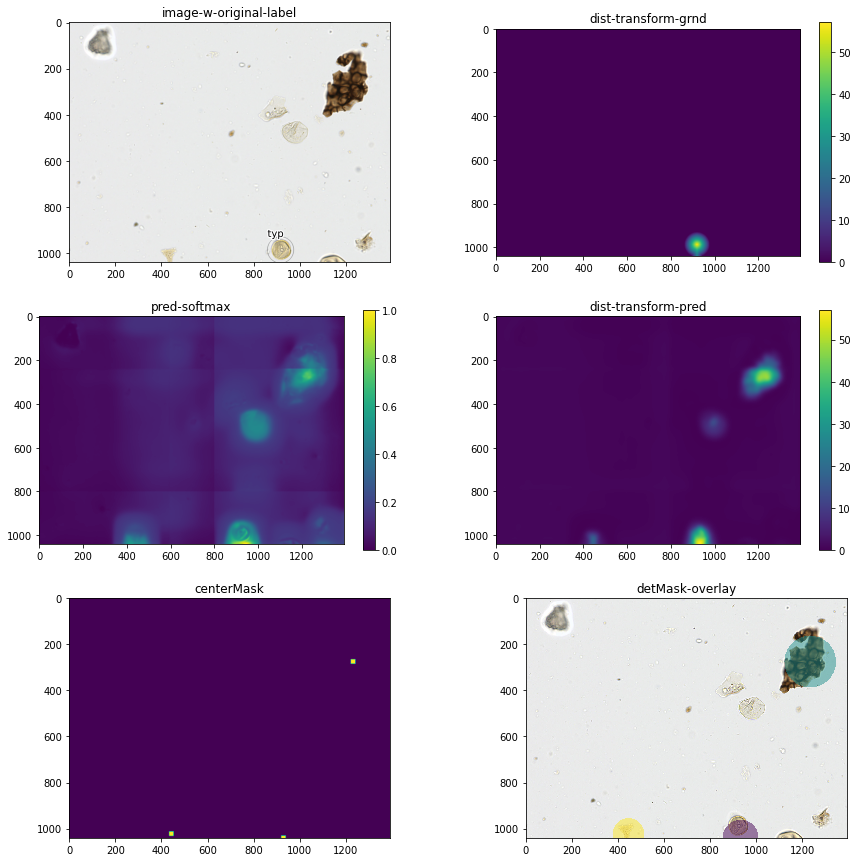

In [32]:
numSample2Show = 1
figWinNumHeight, figWinNumWidth = 3, 2
plt.figure(figsize=(15,15), facecolor='w', edgecolor='k') # figsize -- inch-by-inch
plt.clf()
subwinCount = 1   

plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
subwinCount += 1
slice_path=[]
for idx in range(len(center_radius_list)):
    y = int(center_radius_list[idx][0])
    x = int(center_radius_list[idx][1])
    d = int(center_radius_list[idx][2])
    rr, cc = circle_perimeter(x,y,d, shape=(1040,1392))
    img_with_label[rr, cc] = 0
    plt.text(y-d,x-d, center_radius_list[idx][3],
          fontsize=10,
          color='black', path_effects=[path_effects.withStroke(linewidth=2, foreground="w")])
plt.imshow(img_with_label)
plt.title('image-w-original-label')
# plt.imsave(os.path.join('/content/gdrive/MyDrive/Figures/June 2022','Image_wTags.png'), tmpImg, format='png')

plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
subwinCount += 1
tmpImg = mask_OrgSize
plt.imshow(tmpImg)
#plt.axis('off')
plt.title('dist-transform-grnd')
# plt.imsave(os.path.join('/content/gdrive/MyDrive/Figures/June 2022','dist-transform-grnd.png'), tmpImg, format='png')
plt.colorbar()

plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
subwinCount += 1
tmpImg = (softmax-np.min(softmax))/(np.max(softmax)-np.min(softmax))
plt.imshow(tmpImg)
plt.title('pred-softmax')
plt.colorbar()
# plt.imsave(os.path.join('/content/gdrive/MyDrive/Figures/June 2022','pred-softmax.png'), softmax, format='png')

plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
subwinCount += 1
tmpImg = pred_distanceTransform*100
tmpImg = ((tmpImg - tmpImg.min()) * (1/(tmpImg.max() - tmpImg.min()) * np.max(mask_OrgSize)))
plt.imshow(tmpImg)
plt.colorbar()
plt.title('dist-transform-pred')

plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
subwinCount += 1
plt.imshow(centerMask)
plt.title('centerMask')
# plt.colorbar()
# plt.imsave(os.path.join('/content/gdrive/MyDrive/Figures/June 2022','centerMask.png'), centerMask, format='png')

plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
subwinCount += 1
masked = np.ma.masked_where(detMask == 0, detMask)
plt.imshow(img_without_label, interpolation='none')
plt.imshow(masked, 'viridis', interpolation='none', alpha=0.5)    #'jet' also works as color
plt.title('detMask-overlay')
# plt.imsave(os.path.join('/content/gdrive/MyDrive/Figures/June 2022','detMask-overlay.png'), masked, format='png')

# Create text files with bounding box info for evaluation

In [33]:
print(project_name)
model = ['Tminus1_Model', 'finetunedModel_bestval', 'finetunedModel_epoch84','finetunedModel_bestval2','finetunedModel_bestval3','finetunedModel_bestval4','finetunedModel_bestval5' ]

# 'finetunedModel_bestval2' has further training, but for some reason performance is lower than in bestval
# 'finetunedModel_bestval3' removes confidence threshold
# 'finetunedModel_bestval4' removes threshold for voting4center
# 'finetunedModel_bestval5' removes threshold for voting4center and uses bestValModel_encoder_1 (the true bestval model)

generalizedDet_finetuned_2023_01_10_T1T2T3_forExp2


In [34]:
model = model[0]
detections_dir = os.path.join(eval_dir, model, 'det')
if not os.path.exists(detections_dir): 
    os.makedirs(detections_dir)
gt_dir = os.path.join(eval_dir, model, 'gt')
if not os.path.exists(gt_dir): 
    os.makedirs(gt_dir)

In [35]:
print(detections_dir)

/content/gdrive/MyDrive/eval/final/generalizedDet_finetuned_2023_01_10_T1T2T3_forExp2/Tminus1_Model/det


In [36]:
iterCount, sampleCount = 0, 0
phase = 'test' # 'train'
for sample in dataloaders: 
            
    curImg, curLabel, curMask, curMask_orgSize, current_example = sample
    
    curImg, curLabel, curMask, curMask_orgSize = curImg.to(device), curLabel.to(device), curMask.to(device), curMask_orgSize.to(device)

    curImg_squeeze=torch.squeeze(curImg,0)

    iterCount += 1
    sampleCount += curLabel.size(0)   
    
    outputs = curmodel(curImg_squeeze)
    predSeg = outputs[('segMask', 0)]
    predDistTransform = outputs[('output', 0)]

    softmax = predSeg
    
    if iterCount%50==0:
        print('{}/{}'.format(iterCount,len(det_datasets)))

    #######################################################
    ##       ground-truth: labelOrgSize, mask_peaksOrgSize
    #######################################################
    curmask_OrgSize = curMask_orgSize.squeeze().cpu().detach().numpy()
    GTSegMask = curmask_OrgSize >0
    GTSegMask = measure.label(GTSegMask, background=0)

    props = measure.regionprops(np.squeeze(GTSegMask)) #get the properties of the connected components
    bbox = [prop.bbox for prop in props]   #bounding box coordinates for connected components
    gt_filename = os.path.join(gt_dir, current_example[0][0] + '_' + current_example[1][0] + '_' + current_example[2][0] + '.txt')
    if os.path.exists(gt_filename):
      continue
    # i=2
    gt_info = []
    for i in range(len(props)): 
      class_name="finetuned"   #det
      left = bbox[i][1]
      top = bbox[i][0]
      right = bbox[i][3]
      bottom = bbox[i][2]
      # predDistTransformCrop = predDistTransform[top:bottom, left:right]
      # confidence = np.amax(predDistTransformCrop)
      bbox_info = [class_name, str(left), str(top), str(right), str(bottom)]
      bbox_info = ' '.join(bbox_info)

      gt_info.append(bbox_info)

    # fn = open(gt_filename,'w')
    fn = open(gt_filename,'a')
    for i in gt_info:
      fn.write(i + "\n")
    fn.close()

    ##############################################
    ##          prediction: 
    ##############################################
    # create a list of (800x800) prediction distance transforms crops and softmax crops

    predDistTransform_crops=[]
    softmax_crops = []

    for idx in range(0,4):
      tmpImg =  predDistTransform[idx,:,:,:].squeeze().cpu().detach().numpy() 
      predDistTransform_crops.append(tmpImg)

    for idx in range(0,4):
      tmpImg =  softmax[idx,:,:,:].squeeze().cpu().detach().numpy() 
      softmax_crops.append(tmpImg)

    # create full-sized pred distance transform 
    mask_OrgSize = curMask_orgSize.squeeze().cpu().detach().numpy()

    height,width = mask_OrgSize.shape
    predDistTransform=np.zeros_like(mask_OrgSize)  
    predDistTransform=predDistTransform.astype(np.float32)

    tmp_predDistTransform_1=np.zeros_like(mask_OrgSize).astype(np.float32)
    tmp_predDistTransform_2=np.zeros_like(mask_OrgSize).astype(np.float32)
    tmp_predDistTransform_3=np.zeros_like(mask_OrgSize).astype(np.float32)
    tmp_predDistTransform_4=np.zeros_like(mask_OrgSize).astype(np.float32)


    tmp_predDistTransform_1[0:800, 0:800]=predDistTransform_crops[0]
    tmp_predDistTransform_2[0:800, width-800:]=predDistTransform_crops[1]
    tmp_predDistTransform_3[height-800:, 0:800]=predDistTransform_crops[2]
    tmp_predDistTransform_4[height-800:, width-800:]=predDistTransform_crops[3]

    predDistTransform = np.maximum.reduce([tmp_predDistTransform_1,tmp_predDistTransform_2,tmp_predDistTransform_3,tmp_predDistTransform_4]) 
    predDistTransform = gaussian_filter(predDistTransform, sigma=10) # gaussian blur to get rid of shadow
    pred_distanceTransform = np.copy(predDistTransform)

    # create full-sized softmax
    height,width = mask_OrgSize.shape
    softmax=np.zeros_like(mask_OrgSize)  
    softmax=softmax.astype(np.float32)

    tmp_softmax_1=np.zeros_like(mask_OrgSize).astype(np.float32)
    tmp_softmax_2=np.zeros_like(mask_OrgSize).astype(np.float32)
    tmp_softmax_3=np.zeros_like(mask_OrgSize).astype(np.float32)
    tmp_softmax_4=np.zeros_like(mask_OrgSize).astype(np.float32)

    tmp_softmax_1[0:800, 0:800]=softmax_crops[0]
    tmp_softmax_2[0:800, width-800:]=softmax_crops[1]
    tmp_softmax_3[height-800:, 0:800]=softmax_crops[2]
    tmp_softmax_4[height-800:, width-800:]=softmax_crops[3]

    tmp_softmax_1[tmp_softmax_1 == 0] = np.nan
    tmp_softmax_2[tmp_softmax_2 == 0] = np.nan
    tmp_softmax_3[tmp_softmax_3 == 0] = np.nan
    tmp_softmax_4[tmp_softmax_4 == 0] = np.nan

    # softmax = np.maximum.reduce([tmp_softmax_1,tmp_softmax_2,tmp_softmax_3,tmp_softmax_4]) 
    softmax =  np.nanmean(np.array([tmp_softmax_1,tmp_softmax_2,tmp_softmax_3,tmp_softmax_4]), axis=0)

    # find peaks, zero-out background noise
    voting4center = np.copy(pred_distanceTransform)
    voting4center[voting4center<0.0001] = 0
    coord_peaks = feature.peak_local_max(voting4center, min_distance=50, exclude_border=False) #originally min_distance =5, changed to 25

    # create detection mask using peaks and predicted radius
    detMask = voting4center*0
    predRadiusList = []
    size = (400,400)
    detection_info = []
    detection_info2 = []
    det_filename = os.path.join(detections_dir, current_example[0][0] + '_' + current_example[1][0] + '_' + current_example[2][0]+ '.txt')


    for i in range(coord_peaks.shape[0]):
        y, x = coord_peaks[i]
        #centerMask[y, x] = 1
        # centerMask[y-10:y+10, x-10:x+10] = 1
        # predRadiusList += [voting4center[y,x] *100*800/1000 * 800/1000] # /100.0/self.resizeFactor      # why smaller?
        # predRadiusList += [voting4center[y,x] *100*1000/1000 * 1000/1000]

        left = int(x-(size[0]/2))
        left=max(left,0)
        top = int(y-(size[0]/2))
        top=max(top,0)
        right = int(x+(size[0]/2))
        right=max(right,0)
        bottom = int(y+(size[0]/2))
        bottom=max(bottom,0)

        tmpCrop = softmax[top:bottom, left:right]
        thresh = threshold_otsu(tmpCrop) 
        tmpCrop = tmpCrop> thresh # binarize
        tmpCrop= measure.label(tmpCrop, background=0)
        props = measure.regionprops(tmpCrop) #get the properties of the connected components

        # diameter = [prop.feret_diameter_max for prop in props]
        # diameter = [prop.equivalent_diameter for prop in props]  #diameter for connected components
        diameter = [prop.major_axis_length for prop in props]   #diameter for connected components
        if len(diameter) !=0 and max(diameter)!=0:
          radius = int(max(diameter)/2)
          predRadiusList += [radius]
          a = len(predRadiusList)-1

          tmpMask = voting4center*0
          tmpMask = create_circular_mask(tmpMask, [y, x], predRadiusList[a], value=1)

          #write bb coords to file
          # bbox = [prop.bbox for prop in props]   #bounding box coordinates for connected components

          class_name="finetuned"    #det
          leftBb = x-radius
          leftBb = max(leftBb,0)
          topBb = y-radius
          topBb= max(topBb,0)
          rightBb = x+radius
          rightBb = min(rightBb,tmpMask.shape[1] )
          bottomBb = y+radius
          bottomBb = min(bottomBb,tmpMask.shape[0])

          masked_softmax = np.ma.masked_where(tmpMask==0, softmax) 
          confidence = np.nanmean(masked_softmax)
          if confidence > 0.99:
            confidence = 0
          # bbox_info = [class_name,str(confidence) , str(leftBb), str(topBb), str(rightBb), str(bottomBb)]
          bbox_info2 = [class_name, confidence, leftBb, topBb, rightBb, bottomBb]
          detection_info2.append(bbox_info2)

    # Apply non-max suppression
    NMS_bb = nms(detection_info2,conf_threshold=0, iou_threshold=0.3)
    NMS_bb = NMS_bb[1]


    # fn = open(det_filename,'w')
    fn = open(det_filename,'a')
    for i in NMS_bb:
      fn.write(i + "\n")
    fn.close()

50/180
100/180
150/180


In [ ]:
print(predRadiusList)
print(coord_peaks)
print(NMS_bb)
print(len(NMS_bb))
print(len(detection_info2))

[181, 91, 108, 202, 69, 102, 116, 133, 186, 166, 168, 105, 90, 182, 97, 204, 184, 178, 82]
[[ 777  589]
 [1039  320]
 [ 601  737]
 [ 261  149]
 [ 286 1367]
 [  18  894]
 [ 782  886]
 [ 519  513]
 [ 289  266]
 [ 936  859]
 [ 674 1038]
 [ 160 1060]
 [1039  750]
 [ 471   76]
 [ 295  704]
 [ 402   85]
 [ 651 1294]
 [ 844 1352]
 [   0  116]]
['det 0.3316055 229 948 411 1040', 'det 0.31240752 792 0 996 120', 'det 0.2441138 629 493 845 709', 'det 0.16199642 408 596 770 958', 'det 0.12814316 770 666 1002 898', 'det 0.116206795 1298 217 1392 355', 'det 0.10463728 955 55 1165 265', 'det 0.0838388 380 386 646 652', 'det 0.07694727 693 770 1025 1040', 'det 0.06697596 0 198 289 606', 'det 0.066870295 870 506 1206 842', 'det 0.061992742 607 198 801 392', 'det 0.05952119 660 949 840 1040', 'det 0.05782527 80 103 452 475', 'det 0.047186185 34 0 198 82', 'det 0.041113913 1110 467 1392 835', 'det 0.03641801 1174 666 1392 1022']
17
19


In [ ]:
print(current_example[0])

45568x_47280y


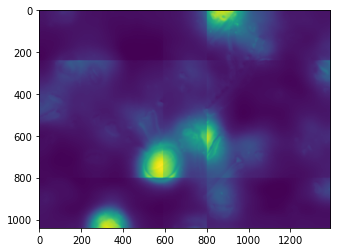

In [ ]:
plt.imshow(softmax)

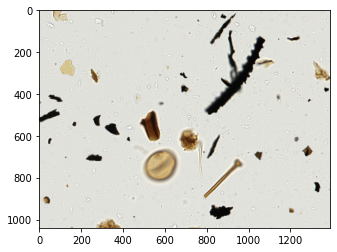

In [ ]:
current_image_path= os.path.join(path_to_image, current_example[0])
for file in sorted(os.listdir(str(current_image_path))):
    if file.endswith('.png'):
      slice = os.path.join(str(current_image_path), file)
      slice_path.append(slice)

      
img = mpimg.imread(slice_path[5])
plt.imshow(img)

0 1135


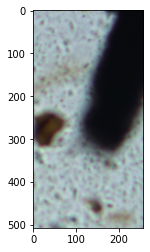

In [ ]:
# crop standardized size box based on predicted center

size=[512,512]
sz = img.shape[:2]
newSz = size[0]

# for i in range(coord_peaks.shape[0]):

i = 0

y, x = coord_peaks[i]
centerMask[y, x] = 1
# centerMask[y-10:y+10, x-10:x+10] = 1
predRadiusList += [voting4center[y,x] *100*800/1000 * 800/1000] # /100.0/self.resizeFactor      # why smaller?
# predRadiusList += [voting4center[y,x] *100*1000/1000 * 1000/1000]
# detMask = create_circular_mask(detMask, [y, x], predRadiusList[i], value=i+1)
# detMask_binary= detMask > 0

yNew_org = y-256
xNew_org = x-256

yNew = max(yNew_org,0)
xNew = max(xNew_org,0)

tmpimg = img[yNew:yNew_org+newSz, xNew:xNew_org+newSz, :].copy()

plt.imshow(tmpimg)
print(yNew,xNew)

# Overlay Visualization

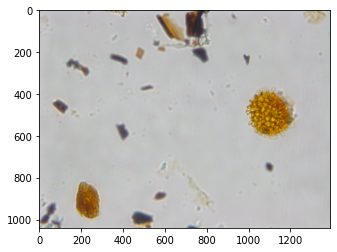

In [ ]:
import matplotlib.image as mpimg

current_image_path=str(current_image_path[0])
for file in sorted(os.listdir(current_image_path)):
    if file.endswith('.bmp'):
      slice = os.path.join(current_image_path, file)

img = mpimg.imread(slice)
plt.imshow(img)

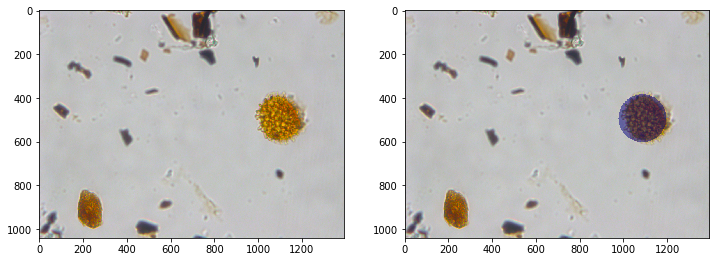

In [ ]:
masked = np.ma.masked_where(detMask == 0, detMask)

plt.figure(figsize=(12,10))
plt.subplot(1,2,1)
plt.imshow(img, interpolation='none')
plt.subplot(1,2,2)
plt.imshow(img, interpolation='none')
plt.imshow(masked, 'jet', interpolation='none', alpha=0.5)
plt.show()


Other useful snippets
-----

In [ ]:
# Print the shape of all tensors in the sample

sample = next(iter(dataloaders))
for idx in range(len(sample)):
  print(sample[idx].shape)

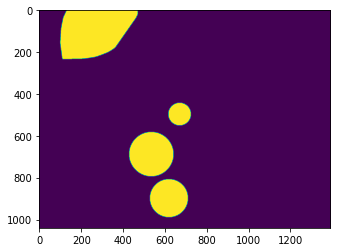

In [ ]:
# Making binary masks from DT

dist_transform = PIL.Image.open('/content/gdrive/MyDrive/UTRECHT/Segmentation/Masks8/PALIV_24-25_slide 1_scan1_19/GT_distTransform.bmp')
dist_transform = np.array(dist_transform)

binary_mask = dist_transform >0.5
im = Image.fromarray((binary_mask*255).astype(np.uint8))
im.save(os.path.join(eval_save_to_folder, 'GT_binaryMask.png'))
plt.imshow(binary_mask)
